In [37]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
# %matplotlib inline
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt
# Importamos librerías para manejo de tiempo
import time

Blur 0.0 segundos
Gradientes 0.015999555587768555 segundos
No-máximos 4.069232702255249 segundos
Histéresis 0.0 segundos
Armado imagen bordes 0.39179325103759766 segundos


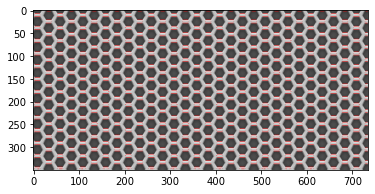

In [40]:
img = cv.imread('metalgrid.jpg')
#print (img.shape)
#plt.imshow(img)
#plt.show()

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Suavizado Gaussiano
#====================
start = time.time()

blur = cv.GaussianBlur(gray,(5,5),0)
#plt.imshow(blur)
#plt.show()

elapsed = time.time()-start
print('Blur {} segundos'.format(elapsed))

# Gradientes
#===========
start = time.time()

# Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_64 = cv.Sobel(blur,cv.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)                  #no importa el signo
sobelx_8u1 = absx_64/absx_64.max()*255            #normaliza a un numero entre 0 y 255, numero real
sobelx_8u = np.uint8(sobelx_8u1)                  #el numero lo hace entero, entre 0 y 255

# De igual modo para Sobely
sobely_64 = cv.Sobel(blur,cv.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)

# De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)
#print ('Matriz de gradientes: \n', mag)

# Encontramos la Dirección y la pasamos a grados
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

#print ('Matriz de angulos: \n',angle)
#print ('Matriz de angulos shape: \n',angle.shape)

elapsed = time.time()-start
print('Gradientes {} segundos'.format(elapsed))

# Supresión de no-máximos
#========================
start = time.time()

# Encontramos los píxels vecinos (b,c) en la dirección (redondeadea) del gradiente y aplicamos la supresión de no-máximos
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0


#print ('Matrix máximos + vecinos: \n', Non_max)
elapsed = time.time()-start
print('No-máximos {} segundos'.format(elapsed))
#print('Matriz de solo máximos: \n',Non_max)

# Umbralizado por histéresis
#===========================
start = time.time()

UmbralAlto = 21
UmbralBajo = 15

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

elapsed = time.time()-start
print('Histéresis {} segundos'.format(elapsed))

# Armo la imagen de bordes
#=========================
start = time.time()
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

elapsed = time.time()-start
print('Armado imagen bordes {} segundos'.format(elapsed))


#Cambio el color de los pixeles que quedaron que a su vez tienen un gradiente en determinada dirección
#Elegir una orientacion del gradiente que se quiera colorear de rojo (0,45,90,135)

img_roja2 = img.copy()
#orientacion_min= 90
#orientacion_max = 90
#INGRESAR ORIENTACIÓN A MARCAR EN COLOR ROJO:
orientacion = 90
orientacion_op = orientacion - 180
for i in range (1,M-1):
    for j in range(1,N-1):
         if ((orientacion -45.5/2 <= angle[i,j] <= orientacion + 45.5/2) or (orientacion_op -45.5/2 <= angle[i,j] <= orientacion_op + 45.5/2)) and (out[i,j] == 255):
        #if (orientacion_min <= angle[i,j] <= orientacion_max) and (out[i,j] == 255):
            img_roja2[i,j] = (250,0,0)
            


# Muestro la imagen
#==================
plt.imshow(img_roja2)
plt.show()

#print ('Tamaño angulos: \n',angle.shape)
#print ('Tamaño out: \n',out.shape)
#print ('Tamaño img: \n',img.shape)
#print ('Tamaño Non Max: \n',Non_max.shape)